In [180]:
%matplotlib inline
import sys
import os
import re
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import sklearn
from sklearn import cross_validation, grid_search
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.externals import joblib

/Users/nathancho/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/nathancho/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [143]:
def create_graph():
    # Creates a tensor graph in the specified directory
    model_dir = 'imagenet'
    with gfile.FastGFile(os.path.join(model_dir,
                    'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

def extraction(list_images):
    """
    Take a list of image file paths, and return features.
    """
    nb_features = 2048
    features = np.empty((len(list_images),nb_features))
    labels = []

    create_graph()

    with tf.Session() as sess:

        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')

        for ind, image in enumerate(list_images):
            if (ind%100 == 0):
                print('Processing %s...' % (image))
            if not gfile.Exists(image):
                tf.logging.fatal('File does not exist %s', image)

            image_data = gfile.FastGFile(image, 'rb').read()

            predictions = sess.run(next_to_last_tensor,
                            {'DecodeJpeg/contents:0': image_data})

            features[ind,:] = np.squeeze(predictions)

            labels.append(re.split('_\d+',image.split('/')[1])[0])

    return features, labels


In [47]:
image_list = images_list('Capstone_photo/Random/')

In [49]:
random_images = extraction(image_list)

Processing Capstone_photo/Random/IMG_9071.JPG...


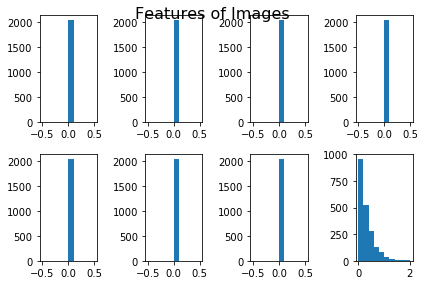

In [55]:
x = np.arange(1,2048)
fig, axes = plt.subplots(2,4)

for ax, i in zip(axes.flatten(),range(len(random_images))):
    ax.hist(random_images[i])

plt.suptitle('Features of Images',fontsize=16)
plt.tight_layout()

In [70]:
train_photos = images_list('train_photos/')

In [64]:
feature, label = extraction(kickflip)

Processing Capstone_photo/Kickflip/IMG_1816.jpg...
Processing Capstone_photo/Kickflip/IMG_1918.jpg...
Processing Capstone_photo/Kickflip/IMG_2117.jpg...
Processing Capstone_photo/Kickflip/IMG_9145.jpg...
Processing Capstone_photo/Kickflip/IMG_9247.jpg...
Processing Capstone_photo/Kickflip/IMG_9444.jpg...


In [71]:
train_photos

[]

In [93]:
sub_dirs = [x[0] for x in gfile.Walk('train_photos/')]

In [94]:
sub_dirs

['train_photos/', 'train_photos/Kickflip', 'train_photos/Ollie']

In [145]:
def image_list(image_dir):
    """Builds a list of training images from the file system.
      Analyzes the sub folders in the image directory, and returns a data structure
      describing the lists of images for each label and their paths.
      Args:
        image_dir: String path to a folder containing subfolders of images.

      Returns:
        A dictionary containing an entry for each label subfolder
      """
    # Checks if the directory name even exists!
    if not gfile.Exists(image_dir):
        print("Image directory '" + image_dir + "' not found.")
        return None
    
    result = {}
    sub_dirs = [x[0] for x in gfile.Walk(image_dir)] # This will create a list of sub directories i.e Kickflip, ollie
    
    is_root_dir = True
    for sub_dir in sub_dirs:
        if is_root_dir:
            is_root_dir = False # Because the first element is the root directory, we skip it to go into the sub directories
            continue
        extensions = ['jpg', 'JPG'] # Image extension
        file_list = [] # File path list of all the images in the directory
        dir_name = os.path.basename(sub_dir) # This will make the dir_name to be 'Kickflip' or 'Ollie'
        if dir_name == image_dir:
            continue
        print("Looking for images in '" + dir_name + "'")
        for extension in extensions:
            file_glob = os.path.join(image_dir, dir_name, '*.' + extension) # Making a file path for all photos with given extension
            file_list.extend(gfile.Glob(file_glob)) # This will add the 'file_glob' string to file_list
        if not file_list:
            print('No files have been found')
            continue
        if len(file_list) < 20: # This will check the length of the file_list
            print('There is less than 20 photos in this directory! There may not be enough pictures!')
        
        label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower()) #This makes the label name for each spacific Image
        
        result[label_name] = file_list #For each label, the list of images associated with the label
        #{'dir':dir_name,'train':file_list}
    
    final = []
    for value in result.values():
        final.extend(value)
    return final
    

# Start Model Testing

In [146]:
train_images = image_list('train_photos')

Looking for images in 'Kickflip'
Looking for images in 'Ollie'


In [147]:
train_images

['train_photos/Kickflip/IMG_1816.jpg',
 'train_photos/Kickflip/IMG_1817.jpg',
 'train_photos/Kickflip/IMG_1818.jpg',
 'train_photos/Kickflip/IMG_1819.jpg',
 'train_photos/Kickflip/IMG_1820.jpg',
 'train_photos/Kickflip/IMG_1821.jpg',
 'train_photos/Kickflip/IMG_1822.jpg',
 'train_photos/Kickflip/IMG_1823.jpg',
 'train_photos/Kickflip/IMG_1824.jpg',
 'train_photos/Kickflip/IMG_1825.jpg',
 'train_photos/Kickflip/IMG_1826.jpg',
 'train_photos/Kickflip/IMG_1827.jpg',
 'train_photos/Kickflip/IMG_1828.jpg',
 'train_photos/Kickflip/IMG_1829.jpg',
 'train_photos/Kickflip/IMG_1830.jpg',
 'train_photos/Kickflip/IMG_1831.jpg',
 'train_photos/Kickflip/IMG_1832.jpg',
 'train_photos/Kickflip/IMG_1833.jpg',
 'train_photos/Kickflip/IMG_1834.jpg',
 'train_photos/Kickflip/IMG_1835.jpg',
 'train_photos/Kickflip/IMG_1836.jpg',
 'train_photos/Kickflip/IMG_1837.jpg',
 'train_photos/Kickflip/IMG_1838.jpg',
 'train_photos/Kickflip/IMG_1839.jpg',
 'train_photos/Kickflip/IMG_1840.jpg',
 'train_photos/Kickflip/I

In [148]:
feature, label = extraction(train_images)

Processing train_photos/Kickflip/IMG_1816.jpg...
Processing train_photos/Kickflip/IMG_1918.jpg...
Processing train_photos/Kickflip/IMG_2117.jpg...
Processing train_photos/Kickflip/IMG_9145.jpg...
Processing train_photos/Kickflip/IMG_9247.jpg...
Processing train_photos/Kickflip/IMG_9444.jpg...
Processing train_photos/Ollie/IMG_1798.jpg...
Processing train_photos/Ollie/IMG_2045.jpg...
Processing train_photos/Ollie/IMG_9066.jpg...
Processing train_photos/Ollie/IMG_9316.jpg...


In [150]:
len(label)

962

In [151]:
feature.shape

(962, 2048)

(0, 2.5)

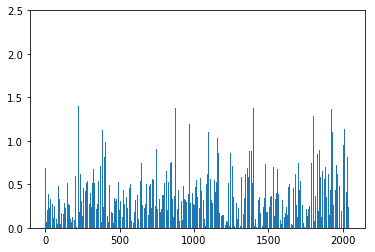

In [176]:
plt.bar(np.arange(0,2048),feature[0]) #Kickflip
plt.ylim(0,2.5)

(0, 2.5)

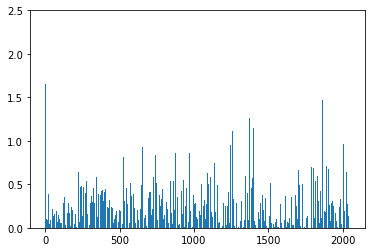

In [179]:
plt.bar(np.arange(0,2048),feature[500]) #ollie
plt.ylim(0,2.5)

In [194]:
def train_svm_classifer(features, labels):
    """
    train_svm_classifer will train a SVM, saved the trained and SVM model and
    report the classification performance

    features: array of input features
    labels: array of labels associated with the input features
    model_output_path: path for storing the trained svm model
    """
    
    
    # save 20% of data for performance evaluation
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, labels, test_size=0.2)

    param = [
        {
            "kernel": ["linear"],
            "C": [1, 10, 100, 1000]
        },
        {
            "kernel": ["rbf"],
            "C": [1, 10, 100, 1000],
            "gamma": [1e-2, 1e-3, 1e-4, 1e-5]
        }
    ]

    # request probability estimation
    svm = SVC(probability=True)

    # 10-fold cross validation, use 4 thread as each fold and each parameter set can be train in parallel
    clf = grid_search.GridSearchCV(svm, param,
            cv=10, n_jobs=4, verbose=3)

    clf.fit(X_train, y_train)

    if os.path.exists(model_output_path):
        joblib.dump(clf.best_estimator_, model_output_path) # Look into pickle file to load into.
    else:
        print("Cannot save trained svm model to {0}.".format(model_output_path))

    print("\nBest parameters set:")
    print(clf.best_params_)

    question = input('\nDo you want to see how the model did? (yes/no):')
    if question.lower() == 'yes':
        y_predict=clf.predict(X_test)

        labels=sorted(list(set(labels)))
        print("\nConfusion matrix:")
        print("Labels: {0}\n".format(",".join(labels)))
        print(confusion_matrix(y_test, y_predict, labels=labels))

        print("\nClassification report:")
        print(classification_report(y_test, y_predict))

In [195]:
train_svm_classifer(feature, label)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=linear ..............................................
[CV] ..................... C=1, kernel=linear, score=0.948052 -   3.3s
[CV] ..................... C=1, kernel=linear, score=0.923077 -   3.4s
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=linear ..............................................
[CV] ..................... C=1, kernel=linear, score=0.974359 -   3.4s
[CV] C=1, kernel=linear ..............................................
[CV] ..................... C=1, kernel=linear, score=0.935065 -   3.5s
[CV] C=1, kernel=linear ..............................................
[CV] ..................... C=1, kernel=linear, score=0.974026 -   3.1s
[CV] C=1, kern

[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   19.8s


[CV] ................... C=100, kernel=linear, score=0.974026 -   3.2s
[CV] ................... C=100, kernel=linear, score=0.935065 -   3.1s
[CV] C=100, kernel=linear ............................................
[CV] C=100, kernel=linear ............................................
[CV] ................... C=100, kernel=linear, score=0.935065 -   3.2s
[CV] C=1000, kernel=linear ...........................................
[CV] ................... C=100, kernel=linear, score=0.986842 -   3.2s
[CV] C=1000, kernel=linear ...........................................
[CV] ................... C=100, kernel=linear, score=0.934211 -   3.1s
[CV] C=1000, kernel=linear ...........................................
[CV] ................... C=100, kernel=linear, score=0.986842 -   3.2s
[CV] C=1000, kernel=linear ...........................................
[CV] .................. C=1000, kernel=linear, score=0.923077 -   3.1s
[CV] C=1000, kernel=linear ...........................................
[CV] .

[CV] ........... C=10, gamma=0.01, kernel=rbf, score=0.974026 -   8.4s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........... C=10, gamma=0.01, kernel=rbf, score=0.948052 -   8.4s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........... C=10, gamma=0.01, kernel=rbf, score=0.974026 -   8.8s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........... C=10, gamma=0.01, kernel=rbf, score=0.922078 -   8.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........... C=10, gamma=0.01, kernel=rbf, score=0.935065 -   9.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ........... C=10, gamma=0.01, kernel=rbf, score=0.960526 -   9.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .......... C=10, gamma=0.001, kernel=rbf, score=0.897436 -   4.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.8min


[CV] .......... C=100, gamma=0.01, kernel=rbf, score=0.923077 -   6.3s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .......... C=100, gamma=0.01, kernel=rbf, score=0.987179 -   6.4s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .......... C=100, gamma=0.01, kernel=rbf, score=0.974026 -   6.5s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .......... C=100, gamma=0.01, kernel=rbf, score=0.948052 -   6.4s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .......... C=100, gamma=0.01, kernel=rbf, score=0.974026 -   6.4s
[CV] .......... C=100, gamma=0.01, kernel=rbf, score=0.922078 -   6.4s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .......... C=100, gamma=0.01, kernel=rbf, score=0.935065 -   6.4s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] .

[CV] ........ C=1000, gamma=0.001, kernel=rbf, score=0.947368 -   3.3s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] ........ C=1000, gamma=0.001, kernel=rbf, score=0.986842 -   3.3s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] ....... C=1000, gamma=0.0001, kernel=rbf, score=0.923077 -   3.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] ....... C=1000, gamma=0.0001, kernel=rbf, score=0.974359 -   3.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] ....... C=1000, gamma=0.0001, kernel=rbf, score=0.935065 -   3.1s
[CV] ....... C=1000, gamma=0.0001, kernel=rbf, score=0.935065 -   3.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] ....... C=1000, gamma=0.0001, kernel=rbf, score=0.974026 -   3.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.4min finished



Best parameters set:
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Do you want to see how the model did? (yes/no):yes

Confusion matrix:
Labels: Kickflip,Ollie

[[106   3]
 [  4  80]]

Classification report:
             precision    recall  f1-score   support

   Kickflip       0.96      0.97      0.97       109
      Ollie       0.96      0.95      0.96        84

avg / total       0.96      0.96      0.96       193



In [97]:
for sub_dir in sub_dirs:
    dir_name = os.path.basename(sub_dir)
    label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower())
    print (label_name)


kickflip
ollie


In [123]:
sys.argv

['/Users/nathancho/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py',
 '-f',
 '/Users/nathancho/Library/Jupyter/runtime/kernel-f03e7a70-a04a-42b7-a7f3-2ef805ad96e8.json']